Just supply the HLS ID and this generates a DSWx-HLS product. 

WIP: Alternatively, specify a product directory with all the products (this is not working quite yet).

In [1]:
from pystac_client import Client  
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import requests
import concurrent.futures
from dem_stitcher import stitch_dem
from dem_stitcher.exceptions import NoDEMCoverage
from dem_stitcher.geoid import read_geoid
from tile_mate import get_raster_from_tiles
import rasterio
import geopandas as gpd
import yaml
from shapely.geometry import box
from dotenv import dotenv_values
import datetime
import re
from dem_stitcher.rio_window import transform_bounds
from rasterio.crs import CRS
import json
import backoff
from proteus.dswx_hls import generate_dswx_layers,get_dswx_hls_cli_parser, parse_runconfig_file


# Parameters

If you specify a directory for HLS layers, assume all the files are in a directory - directory should not mix products!

In [2]:
HLS_ID_OR_HLS_DIR_PATH = 'HLS.S30.T53KMA.2021258T011731.v2.0' # either all files are in a directory
OUT_DIR = 'out'
AEROSOL_PARAM = True
DOWNLOAD_HLS = True

# Accounting

In [3]:
if DOWNLOAD_HLS:
    assert HLS_ID_OR_HLS_DIR_PATH[:7] in ['HLS.L30', 'HLS.S30']
    HLS_ID = HLS_ID_OR_HLS_DIR_PATH
else:
    dir_path = Path(HLS_ID_OR_HLS_DIR_PATH)
    assert dir_path.exists()
    assert dir_path.is_dir()
    tifs = sorted(list((dir_path).glob('*.tif')))
    # HLS.L30.T22UCU.2021266T142337.v2.0.B01.tif
    HLS_ID = '.'.join(tifs[0].stem.split('.')[:-1])
HLS_ID

'HLS.S30.T53KMA.2021258T011731.v2.0'

In [4]:
OUT_DIR = Path(OUT_DIR)
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [5]:
config = dotenv_values()

ED_USERNAME = config['ED_USERNAME']
ED_PASSWORD = config['ED_PASSWORD']

In [6]:
work_dir = Path('work') / HLS_ID
work_dir.mkdir(exist_ok=True, parents=True)

## DSWx ID

In [7]:
def get_dswx_id(hls_id: str):
    # Source: https://github.com/nasa/opera-sds-pcm/blob/83ed093f90fc7ed298f6bfc3a82f6aa48aece5e2/tools/ops/cnm_check.py#L84
    m = re.match(
        r'(?P<product_shortname>HLS[.]([LS])30)[.]'
        r'(?P<tile_id>T[^\W_]{5})[.]'
        r'(?P<acquisition_ts>(?P<year>\d{4})(?P<day_of_year>\d{3})T(?P<hour>\d{2})(?P<minute>\d{2})(?P<second>\d{2}))[.]'
        r'(?P<collection_version>v\d+[.]\d+)$',
        hls_id
    )
    tile = m.group("tile_id")
    year = m.group("year")
    doy = m.group("day_of_year")
    time_of_day = m.group("acquisition_ts").split("T")[1]
    date = datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(doy) - 1)
    dswx_acquisition_dt_str = f"{date.strftime('%Y%m%d')}T{time_of_day}"

    now = datetime.datetime.now()
    now_str = now.strftime('%Y%m%d%H%S')
    dswx_id = f'OPERA_L3_DSWx-HLS_{tile}_{dswx_acquisition_dt_str}Z_{now_str}Z'

    return dswx_id

dswx_id = get_dswx_id(HLS_ID)
dswx_id

'OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z'

In [8]:
product_version = 1.0

# This is where DSWx will get written
output_dir = OUT_DIR / f'{dswx_id}_{product_version}'
output_dir.mkdir(exist_ok=True, parents=True)

In [9]:
data = {'hls_id': HLS_ID,
        'dswx_product_dir': str(output_dir)}
json.dump(data,
          open(output_dir / 'hls_dswx_dict.json', 'w'))

# Download HLS Tile

In [10]:
hls_dir = work_dir / HLS_ID
hls_dir.mkdir(exist_ok=True, parents=True)

In [11]:
# Source: https://urs.earthdata.nasa.gov/documentation/for_users/data_access/python
class SessionWithHeaderRedirection(requests.Session):
    AUTH_HOST = 'urs.earthdata.nasa.gov'
    def __init__(self, username, password):
        super().__init__()
        self.auth = (username, password)


    def rebuild_auth(self, prepared_request, response):
        headers = prepared_request.headers
        url = prepared_request.url
        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)
            if (original_parsed.hostname != redirect_parsed.hostname) and \
                    redirect_parsed.hostname != self.AUTH_HOST and \
                    original_parsed.hostname != self.AUTH_HOST:
                del headers['Authorization']

        return

In [12]:
@backoff.on_exception(backoff.expo,
                      Exception,
                      max_tries=10)
def download_one(url: str, work_dir: Path = hls_dir):
    # Source: https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests
    local_filename = work_dir / url.split('/')[-1]
    session = SessionWithHeaderRedirection(ED_USERNAME, ED_PASSWORD)
    with session.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return local_filename

@backoff.on_exception(backoff.expo,
                      Exception,
                      max_tries=10)
def get_hls_urls(hls_id: str) -> list[str]:
    STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
    api = Client.open(f'{STAC_URL}/LPCLOUD/')
    hls_collections = ['HLSL30.v2.0', 'HLSS30.v2.0']

    search_params = {"collections": hls_collections,
                     "ids": [HLS_ID],
                     "max_items": 5}
    resp = api.search(**search_params)
    resp_items = resp.item_collection()

    urls = [asset.href for asset in resp_items[0].assets.values() if asset.href[-4:] not in ['.xml', '.jpg']]
    return urls
    
def download_hls_data(hls_id: str) -> list[str]:
    urls = get_hls_urls(hls_id)
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        hls_paths = list(tqdm(executor.map(download_one, urls), total=len(urls)))
    return sorted(hls_paths)

In [13]:
hls_paths = download_hls_data(HLS_ID)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:41<00:00,  2.29s/it]


I don't think we need filter out tif files not used based on this issue ticket: https://github.com/nasa/PROTEUS/pull/15

In [14]:
hls_paths_filtered = hls_paths # [p for p in hls_paths if not any([substring in p.name for substring in ['SAA.tif', 'SZA.tif', 'VAA.tif', 'VZA.tif']])]
hls_paths_filtered

[PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B01.tif'),
 PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B02.tif'),
 PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B03.tif'),
 PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B04.tif'),
 PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B05.tif'),
 PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B06.tif'),
 PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B07.tif'),
 PosixPath('work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.20

# HLS Bounds (with a buffer)

Get bounds of HLS tile

In [15]:
with rasterio.open(hls_paths_filtered[0]) as ds:
    org_bounds = list(ds.bounds)
    hls_crs = ds.crs
org_bounds_4326 = transform_bounds(org_bounds, hls_crs, CRS.from_epsg(4326))

hls_bounds = box(*org_bounds_4326).buffer(.25).bounds
hls_bounds

(133.8041012239109,
 -18.424596638694386,
 135.34178227524004,
 -16.93442912213914)

# Auxiliary Datasets

## DEM

In [16]:
dst_area_or_point = 'Point'
try:
    dem, p_dem = stitch_dem(hls_bounds, 
                            'glo_30', 
                            dst_area_or_point=dst_area_or_point, 
                            dst_ellipsoidal_height=True)
except NoDEMCoverage:
    print('no DEM coverage')
    dem, p_dem = read_geoid('egm_08', hls_bounds, res_buffer=1)
    # removes extra channel; guess we could have used squeeze too
    dem = dem[0, ...]

Reading glo_30 Datasets: 100%|█████████████████████████████████████████████| 9/9 [00:14<00:00,  1.58s/it]


In [17]:
dem_path = work_dir / 'glo_30.tif'

In [18]:
with rasterio.open(dem_path, 'w', **p_dem) as ds:
   ds.write(dem, 1)
   ds.update_tags(AREA_OR_POINT=dst_area_or_point)

## ESA 10 m world cover

In [19]:
X_esa_wc, p_wc = get_raster_from_tiles(hls_bounds, 
                                       tile_shortname='esa_world_cover_2021')

In [20]:
wc_10m_path = work_dir / f'wc_10m.tif'

In [21]:
with rasterio.open(wc_10m_path, 'w', **p_wc) as ds:
    ds.write(X_esa_wc)
    # See: https://github.com/nasa/PROTEUS/blob/e5b411a91d5e78bc1479ba6d146ce62a29823e49/src/proteus/dswx_hls.py#L1053-L1088
    ds.update_tags(time_end='2021-12-31T23:59:59Z',
                   time_start='2021-01-01T00:00:00Z')

In [22]:
# with rasterio.open('https://esa-worldcover.s3.eu-central-1.amazonaws.com/v200/2021/map/ESA_WorldCover_10m_2021_v200_S18E135_Map.tif') as ds:
#     tags = ds.tags()

# tags

# ESA 100 m World Cover

In [23]:
wc_100m_path =  work_dir / f'wc_100m.tif'

In [24]:
X_cop100, p_cop100 = get_raster_from_tiles(hls_bounds, 
                                           tile_shortname='cop_100_lulc_discrete',
                                           year=2019)

In [25]:
with rasterio.open(wc_100m_path, 'w', **p_cop100) as ds:
    ds.write(X_cop100)

## NOAA GSHHS

Commented out because it's not necessary when ocean mapping is not applied.

In [26]:
# %%time

# #coastline_url = 'http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip' # Source: https://www.soest.hawaii.edu/pwessel/gshhg/index.html
# coastline_url = ('https://asf-dem-west.s3.us-west-2.amazonaws.com'
#                  '/WATER_MASK/GSHHG/GSHHS_shp/f/GSHHS_f_L1.shp')

# df = gpd.read_file(coastline_url, bbox=hls_bounds)
# df.head()

In [27]:
# coastline_path = work_dir / 'gshhs_coastline'
# coastline_path_shp = coastline_path / (coastline_path.stem + '.shp')

In [28]:
# df.to_file(coastline_path)

## Delete all the data from memory

In [29]:
del dem
# del df
del X_cop100
del X_esa_wc

# Run DSWx

In [30]:
dswx_hls_runconfig_url = 'https://raw.githubusercontent.com/nasa/PROTEUS/main/src/proteus/defaults/dswx_hls.yaml'

In [31]:
resp = requests.get(dswx_hls_runconfig_url)
runconfig_dict = yaml.safe_load(resp.content)
runconfig_dict

{'runconfig': {'name': 'dswx_hls_workflow_default',
  'groups': {'pge_name_group': {'pge_name': 'DSWX_HLS_PGE'},
   'input_file_group': {'input_file_path': None},
   'dynamic_ancillary_file_group': {'dem_file': None,
    'dem_file_description': None,
    'landcover_file': None,
    'landcover_file_description': None,
    'worldcover_file': None,
    'worldcover_file_description': None,
    'shoreline_shapefile': None,
    'shoreline_shapefile_description': None},
   'primary_executable': {'product_type': 'DSWX_HLS'},
   'product_path_group': {'product_path': None,
    'scratch_path': None,
    'output_dir': None,
    'product_id': None,
    'product_version': None},
   'processing': {'check_ancillary_inputs_coverage': True,
    'apply_ocean_masking': False,
    'apply_aerosol_class_remapping': True,
    'aerosol_not_water_to_high_conf_water_fmask_values': [224, 160, 96],
    'aerosol_water_moderate_conf_to_high_conf_water_fmask_values': [224,
     160,
     96],
    'aerosol_partial_su

In [32]:
input_directory = str(hls_paths_filtered[0].parent.resolve())
hls_threshold = runconfig_dict['runconfig']['groups']['hls_thresholds']
hls_threshold

{'wigt': 0.124,
 'awgt': 0.0,
 'pswt_1_mndwi': -0.44,
 'pswt_1_nir': 1500,
 'pswt_1_swir1': 900,
 'pswt_1_ndvi': 0.7,
 'pswt_2_mndwi': -0.5,
 'pswt_2_blue': 1000,
 'pswt_2_nir': 2500,
 'pswt_2_swir1': 3000,
 'pswt_2_swir2': 1000,
 'lcmask_nir': 1200}

In [33]:
hls_paths_str = [str(p.resolve()) for p in sorted(hls_paths_filtered)]
hls_paths_str[:2]

['/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B01.tif',
 '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B02.tif']

In [34]:
runconfig_dict['runconfig']['groups']['processing']['apply_aerosol_class_remapping'] = AEROSOL_PARAM

In [35]:
s = str([str(hls_paths[0].parent.resolve())]).replace("'", "")
s

'[/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0]'

In [36]:
runconfig_dict['runconfig']['groups']['input_file_group']['input_file_path'] = hls_paths_str# [str(hls_paths_filtered[0].parent.resolve())]
runconfig_dict['runconfig']['groups']['dynamic_ancillary_file_group']['dem_file'] = str(dem_path.resolve())
runconfig_dict['runconfig']['groups']['dynamic_ancillary_file_group']['landcover_file'] = str(wc_100m_path.resolve())
runconfig_dict['runconfig']['groups']['dynamic_ancillary_file_group']['worldcover_file'] = str(wc_10m_path.resolve())
#runconfig_dict['runconfig']['groups']['dynamic_ancillary_file_group']['worldcover_file_description'] = '2021'

#runconfig_dict['runconfig']['groups']['dynamic_ancillary_file_group']['shoreline_shapefile'] = str(coastline_path_shp.resolve())

In [37]:
product_path = work_dir / 'product'
scratch_path = work_dir / 'scratch'

runconfig_dict['runconfig']['groups']['product_path_group']['product_path'] = str(product_path.resolve())
runconfig_dict['runconfig']['groups']['product_path_group']['scratch_path'] = str(scratch_path.resolve())
runconfig_dict['runconfig']['groups']['product_path_group']['product_version'] = product_version
runconfig_dict['runconfig']['groups']['product_path_group']['product_id'] = dswx_id
runconfig_dict['runconfig']['groups']['product_path_group']['output_dir'] = str(output_dir)

In [38]:
runconfig_path = work_dir/ 'runconfig.yaml'
with open(runconfig_path, 'w') as f:
    yaml.safe_dump(runconfig_dict, f, default_flow_style=False)

We use [this](https://github.com/nasa/PROTEUS/blob/main/tests/test_dswx_hls_workflow.py) to get python error-handling. Still a little opaque with runconfig ingestion, but the args should be readable.

In [39]:
parser = get_dswx_hls_cli_parser()
args = parser.parse_args([f'{input_directory}'])
runconfig_constants = parse_runconfig_file(user_runconfig_file=str(runconfig_path.resolve()), 
                                           args=args)
args.__dict__

{'input_list': ['/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B01.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B02.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B03.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B04.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B05.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258

In [40]:
(args.input_list,
args.forest_mask_landcover_classes, 
args.apply_aerosol_class_remapping, 
args.output_non_masked_dswx, 
args.landcover_file, 
args.output_landcover)

(['/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B01.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B02.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B03.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B04.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0.B05.tif',
  '/Users/cmarshak/bekaert-team/dswx-hls-pst-workflow/work/HLS.S30.T53KMA.2021258T011731.v2.0/HLS.S30.T53KMA.2021258T011731.v2.0/H

In [41]:
generate_dswx_layers(
        args.input_list,
        args.output_file,
        hls_thresholds = runconfig_constants.hls_thresholds,
        dem_file=args.dem_file,
        dem_file_description=args.dem_file_description,
        output_interpreted_band=args.output_interpreted_band,
        output_rgb_file=args.output_rgb_file,
        output_infrared_rgb_file=args.output_infrared_rgb_file,
        output_binary_water=args.output_binary_water,
        output_confidence_layer=args.output_confidence_layer,
        output_diagnostic_layer=args.output_diagnostic_layer,
        output_non_masked_dswx=args.output_non_masked_dswx,
        output_shadow_masked_dswx=args.output_shadow_masked_dswx,
        output_landcover=args.output_landcover,
        output_shadow_layer=args.output_shadow_layer,
        output_cloud_layer=args.output_cloud_layer,
        output_dem_layer=args.output_dem_layer,
        output_browse_image=args.output_browse_image,
        browse_image_height=args.browse_image_height,
        browse_image_width=args.browse_image_width,
        exclude_psw_aggressive_in_browse=args.exclude_psw_aggressive_in_browse,
        not_water_in_browse=args.not_water_in_browse,
        cloud_in_browse=args.cloud_in_browse,
        snow_in_browse=args.snow_in_browse,
        landcover_file=args.landcover_file,
        landcover_file_description=args.landcover_file_description,
        worldcover_file=args.worldcover_file,
        worldcover_file_description=args.worldcover_file_description,
        shoreline_shapefile=args.shoreline_shapefile,
        shoreline_shapefile_description=args.shoreline_shapefile_description,
        flag_offset_and_scale_inputs=args.flag_offset_and_scale_inputs,
        scratch_dir=args.scratch_dir,
        product_id=args.product_id,
        product_version=args.product_version,
        check_ancillary_inputs_coverage=args.check_ancillary_inputs_coverage,
        apply_ocean_masking=args.apply_ocean_masking,
        apply_aerosol_class_remapping=args.apply_aerosol_class_remapping,
        aerosol_not_water_to_high_conf_water_fmask_values =
            args.aerosol_not_water_to_high_conf_water_fmask_values,
        aerosol_water_moderate_conf_to_high_conf_water_fmask_values =
            args.aerosol_water_moderate_conf_to_high_conf_water_fmask_values,
        aerosol_partial_surface_water_conservative_to_high_conf_water_fmask_values =
            args.aerosol_partial_surface_water_conservative_to_high_conf_water_fmask_values,
        aerosol_partial_surface_aggressive_to_high_conf_water_fmask_values =
            args.aerosol_partial_surface_aggressive_to_high_conf_water_fmask_values,
        shadow_masking_algorithm=args.shadow_masking_algorithm,
        min_slope_angle = args.min_slope_angle,
        max_sun_local_inc_angle=args.max_sun_local_inc_angle,
        mask_adjacent_to_cloud_mode=args.mask_adjacent_to_cloud_mode,
        forest_mask_landcover_classes=args.forest_mask_landcover_classes,
        ocean_masking_shoreline_distance_km = \
            args.ocean_masking_shoreline_distance_km,
        flag_debug=args.flag_debug)

/Users/cmarshak/mambaforge/envs/dswx_hls_generation/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0...10...20...30...40...50...60...70...80...90...out/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_1.0/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_v1.0_B10_DEM.tif is a valid cloud optimized GeoTIFF

The size of all IFD headers is 4778 bytes
100 - done.
0...10...20...30...40...50...60...70...80...90...out/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_1.0/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_v1.0_B08_SHAD.tif is a valid cloud optimized GeoTIFF

The size of all IFD headers is 12456 bytes
100 - done.
0...10...20...30...40...50...60...70...80...90...out/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_1.0/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_v1.0_B07_LAND.tif is a valid cloud optimized GeoTIFF

The size of all IFD headers is 12520 bytes
100 - done.
0...10...20...30...40...50...60...70...80...90...out/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_1.0/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z

True

# Inspect

In [42]:
wtr_path = list(output_dir.glob('*WTR.tif'))[0]
wtr_path

PosixPath('out/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_1.0/OPERA_L3_DSWx-HLS_T53KMA_20210915T011731Z_202401161621Z_v1.0_B01_WTR.tif')

In [43]:
with rasterio.open(wtr_path) as ds:
    X = ds.read(1)
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 53, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",135],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 399960.0,
       0.0, -30.0, -1899960.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

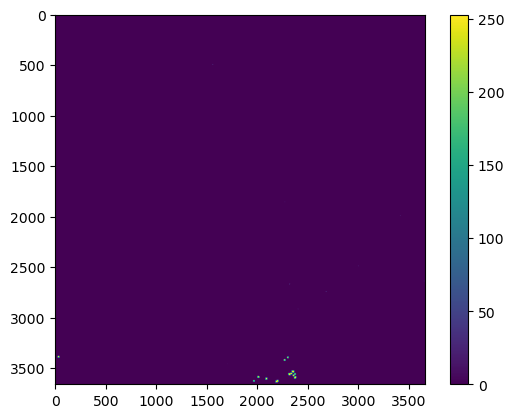

In [44]:
plt.imshow(X)
plt.colorbar()